<a href="https://colab.research.google.com/github/PhilipMathieu/access/blob/main/portland_greenspace_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install necessary libraries
!pip install --upgrade geopandas contextily osmnx

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import json
import urllib.parse
import os.path
import contextily as cx
ox.settings.cache_folder = "../cache/"

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,10)

## Set Boundary

Load a shapefile containing the boundary of the city of Portland, ME. This will be used to determine which Census tracts to include.

In [3]:
portland_boundary = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=3857&f=json")

## Load census tracts

In [4]:
!wget -nc https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_23_tract.zip -P ../data/tracts/

File ‘../data/tracts/tl_2022_23_tract.zip’ already there; not retrieving.



In [5]:
tracts = gpd.read_file("../data/tracts/tl_2022_23_tract.zip").set_index('GEOID').to_crs('EPSG:3857').clip(portland_boundary)

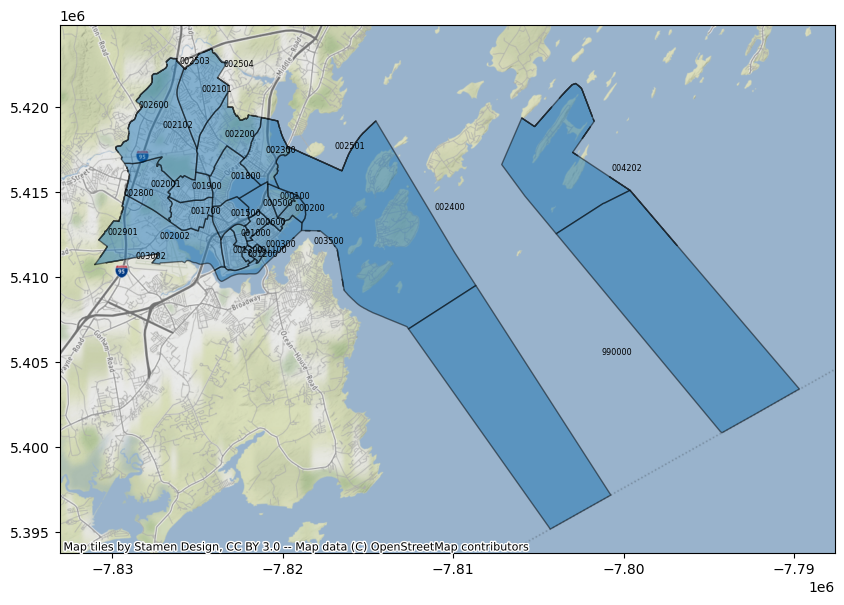

In [6]:
ax = tracts.plot(alpha=0.5, edgecolor='k')
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})
cx.add_basemap(ax)

Because this approach assumes walking distance, results aren't valid for islands. For the time being, we can accomodate this by manually removing the islands.

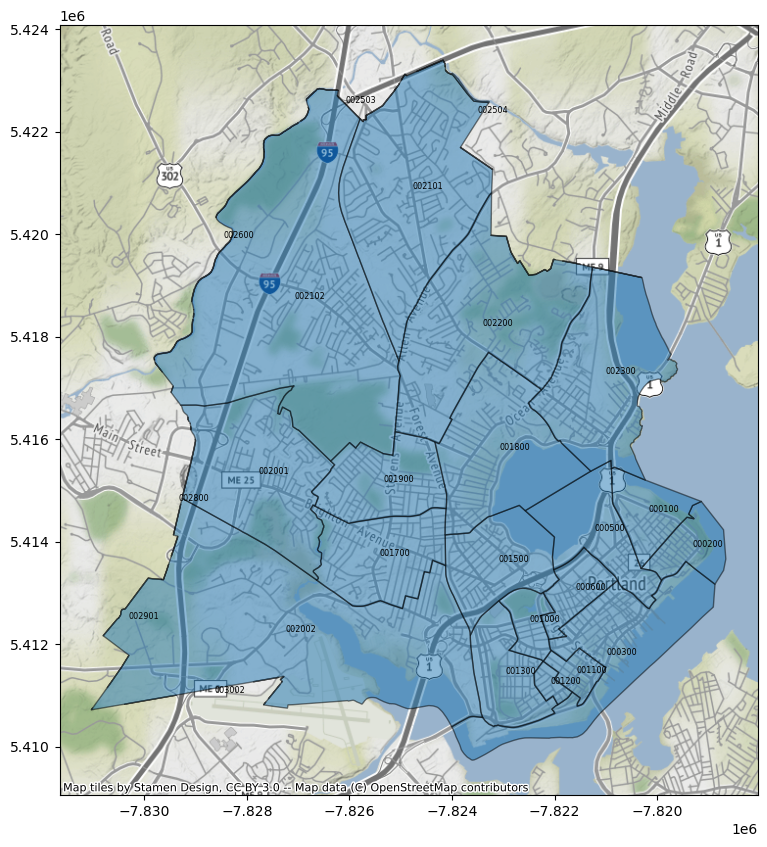

In [7]:
# manually remove islands
tracts = tracts.drop(['23005990000', '23005004202', '23005002400', '23005003500', '23005002501'])
ax = tracts.plot(alpha=0.5, edgecolor='k')
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})
cx.add_basemap(ax)

## Download and prep the street network

This is usually the most time-consuming step, as the size of the graph could be arbitrarily large. To speed up computation, download the graph separately and load it from local storage.

In [8]:
filepath = "../data/graphs/greater_portland.graphml"

if os.path.isfile(filepath):
  # load from file
  G = ox.load_graphml(filepath)
else:
  # download the street network
  bbox = tracts.to_crs("EPSG:4326").geometry.unary_union.envelope.bounds
  buffer = 0.05 # unit is lat/lon degrees
  network_type = "walk"
  G = ox.graph_from_bbox(bbox[3]+buffer, bbox[1]-buffer, bbox[2]+buffer, bbox[0]-buffer, network_type=network_type)
  ox.save_graphml(G, filepath)

G = ox.project_graph(G, 'EPSG:3857') # project the graph to UTM for this zone

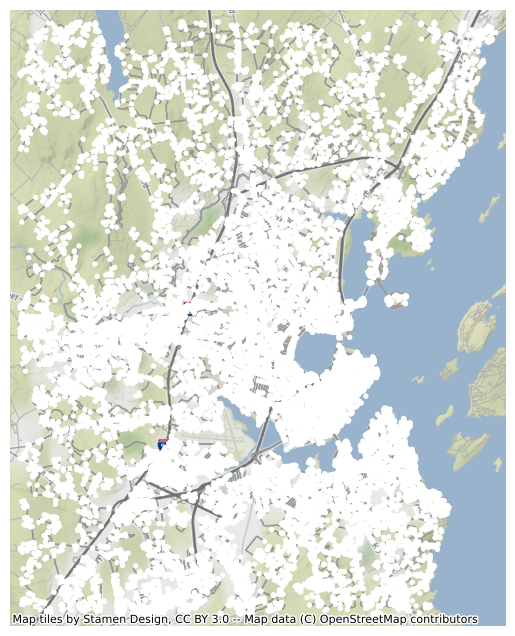

In [9]:
fig, ax = ox.plot_graph(G, bgcolor=None, show=False, close=False)
cx.add_basemap(ax)

For each census tract, we need to find the closest node on the graph. (This will allow us to compute distance entirely in terms of graph distance, as opposed to relying on spatial projections which are both slower and possibly less accurate.)

Median Distance:  72 m


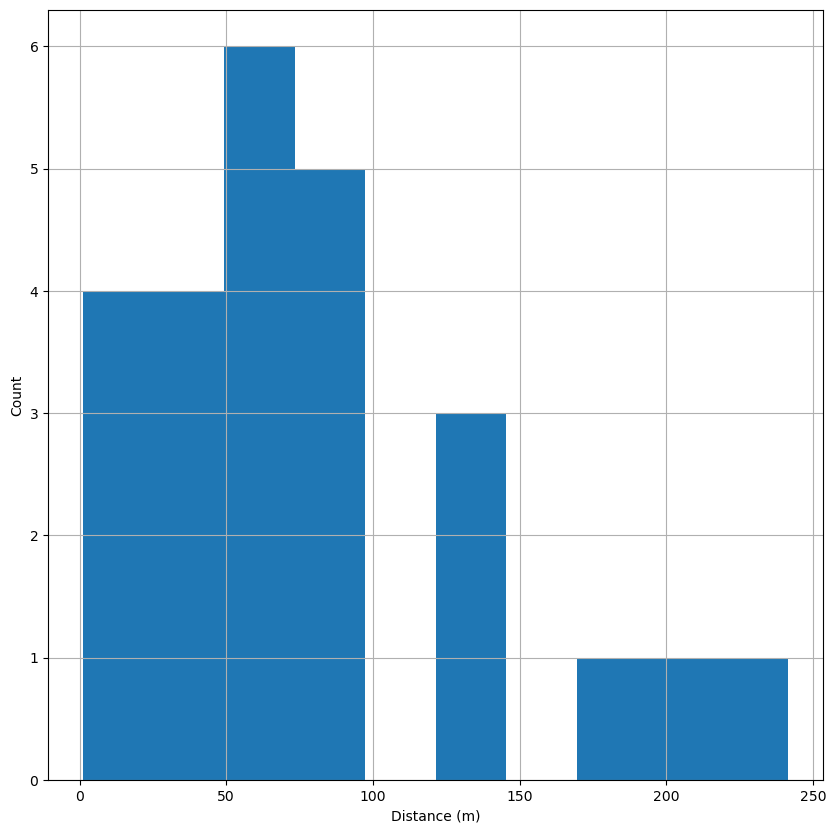

In [10]:
# use a spatial index to efficiently find nearest nodes
gdf_nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
center_nodes = gdf_nodes.loc[gdf_nodes.sindex.nearest(tracts.centroid)[1]]["osmid"].values
center_nodes_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

# verify that nodes are reasonably close
dists = center_nodes_gdf.distance(tracts.centroid, align=False)
ax = dists.hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print("Median Distance: {:3.0f} m".format(dists.median()))

## Plot nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, 30, 45, and 60 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [11]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 30, 45, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [12]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [13]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

Plotting node 101625302


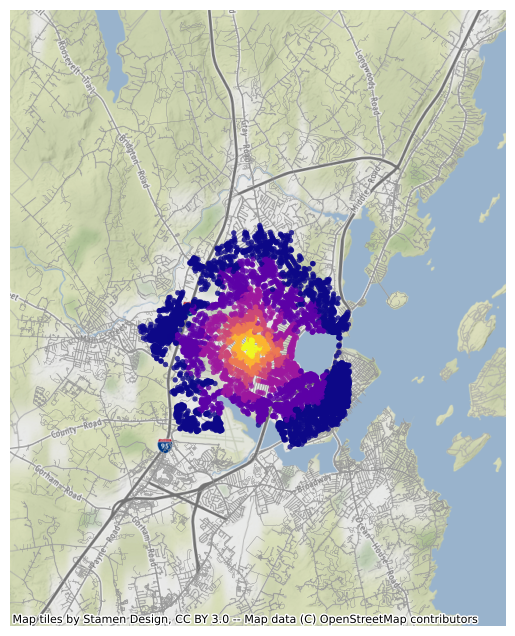

In [14]:
center_node = center_nodes[18]
print("Plotting node {}".format(center_node))
# color the nodes according to isochrone then plot the street network
node_times = {}
node_colors = {}
# loop over allowed trip times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    # find subgraph from center node
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # color nodes according to the isoline
    for node in subgraph.nodes():
        node_times[node] = trip_time
        node_colors[node] = color
# set node size and color for unreachable nodes
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
# show the result
fig, ax = ox.plot_graph(
    G,
    bgcolor=None,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",show=False, close=False
)
cx.add_basemap(ax)

## Plot the time-distances as isochrones

Rather than just labelling the nodes by walk time, it's convenient to generate convex polygons that approximate the area within each walk time. This will facilitate spatial analysis later on.

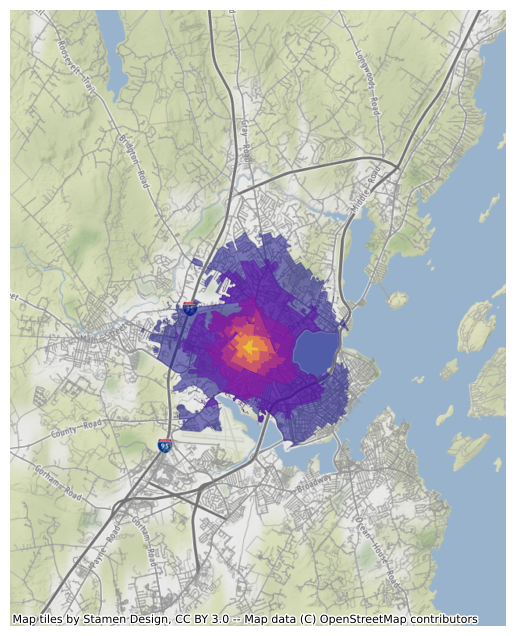

In [15]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=5, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame.from_dict({"trip_times":trip_times, "geometry":isochrone_polys}, crs="EPSG:3857")

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, bgcolor=None, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.5)
cx.add_basemap(ax)
plt.show()

## Load Conserved Lands based on bounding box
The next step is to use the walk time polygons to find conserved lands within each walk time. We start by getting all conserved lands in and near our isochrones.

In [16]:
# make an ESRI geometry JSON object from the bounding box
# https://developers.arcgis.com/rest/services-reference/enterprise/query-map-service-layer-.htm
bbox_json = json.dumps({"points":gdf.geometry.unary_union.envelope.exterior.coords[:]})
bbox_json

'{"points": [[-7830699.680182039, 5410244.126363409], [-7820426.550868578, 5410244.126363409], [-7820426.550868578, 5421119.13876639], [-7830699.680182039, 5421119.13876639], [-7830699.680182039, 5410244.126363409]]}'

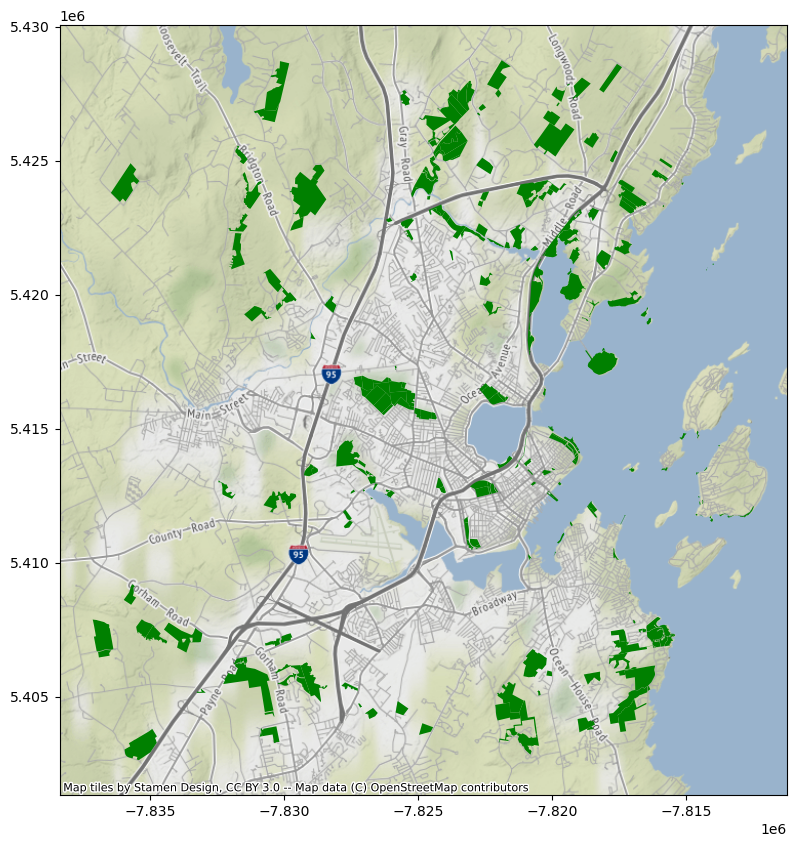

In [17]:
# get all conserved parcels within 3 mile radius of this polygon
lands = gpd.read_file("https://gis.maine.gov/arcgis/rest/services/acf/Conserved_Lands/MapServer/0/query?"+
                      "where=&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry="+
                      urllib.parse.quote(bbox_json)+
                      "&geometryType=esriGeometryMultipoint&inSR=3857&spatialRel=esriSpatialRelEnvelopeIntersects&"+
                      "distance="+str(3)+"&units=esriSRUnit_StatuteMile&outFields=*&returnGeometry=true&returnTrueCurves=false&outSR=3857&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson")
ax = lands.plot(color='g')
cx.add_basemap(ax)

## Identify Conserved Lands within Isochrones
Here again we map each land to its centroid, then each centroid to the nearest graph node.

In [18]:
# use a spatial index to efficiently find nearest nodes
gdf_nodes_cl = ox.graph_to_gdfs(G, edges=False).reset_index()
center_nodes_cl = gdf_nodes.loc[gdf_nodes.sindex.nearest(lands.centroid)[1]]["osmid"].values
center_nodes_cl_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes_cl]

Median Distance: 102 m


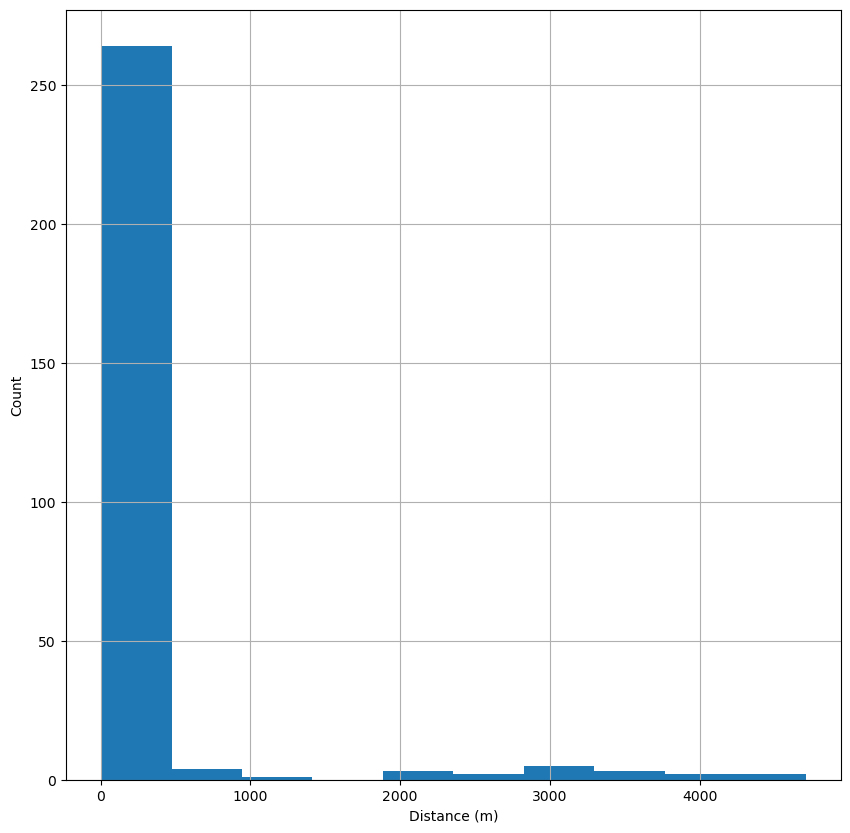

In [19]:
# verify that nodes are reasonably close
dists = center_nodes_cl_gdf.distance(lands.centroid, align=False)
ax = dists.hist()
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Count")
print("Median Distance: {:3.0f} m".format(dists.median()))

In [20]:
# create a dataframe with the points
times = [node_times[node] if node in node_times else None for node in center_nodes_cl]
lands_points = lands.copy()
lands_points["geometry"] = center_nodes_cl_gdf.reset_index()["geometry"]
lands_points["trip_times"] = times
lands_colors = [node_colors[node] if node in node_colors else "none" for node in center_nodes_cl]

How many conserved lands are within each trip time?

In [21]:
# calculate the number of lands within each trip time
lands_points.groupby("trip_times")["OBJECTID"].count()

trip_times
10.0     3
15.0     5
20.0     6
30.0     9
45.0    19
60.0    26
Name: OBJECTID, dtype: int64

What area of conserved land is within each trip time?

In [22]:
lands_points.groupby("trip_times")["CALC_AC"].sum()

trip_times
10.0     28.083650
15.0     44.625488
20.0    147.134227
30.0     72.280626
45.0    211.292286
60.0     83.598665
Name: CALC_AC, dtype: float64

Where are the different properties on the map?

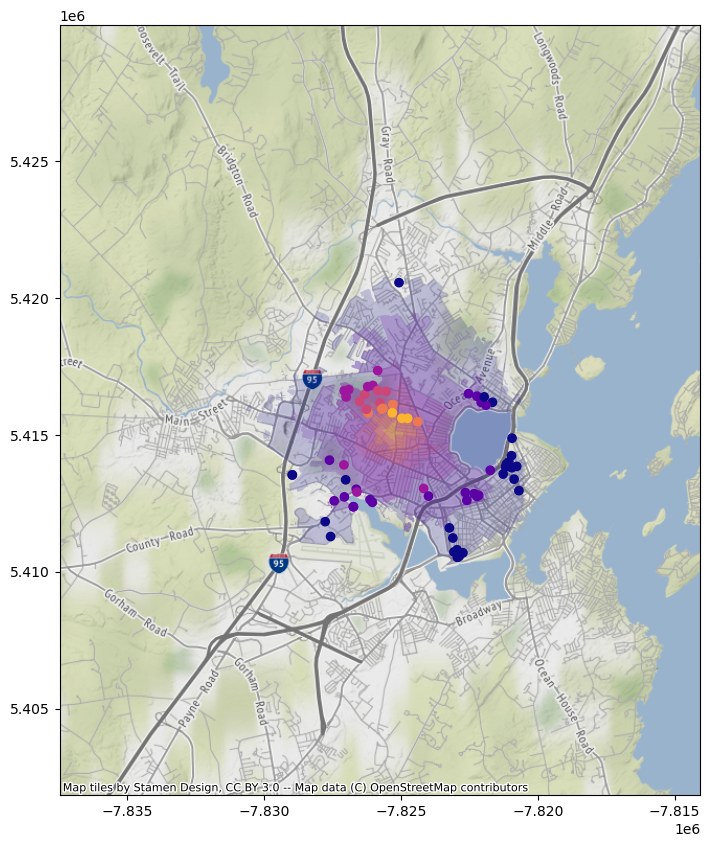

In [23]:
# plot the network then add isochrones as colored polygon patches
fig, ax = plt.subplots()
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.2)
lands_points.plot(ax=ax, color=lands_colors)
cx.add_basemap(ax)
plt.show()

List the properties by walk time

In [24]:
lands_points.sort_values("trip_times")

created_user   created_date last_edited_user  last_edited_date  \
53   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
63   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
142  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
37   MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
262  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
..           ...            ...              ...               ...   
278  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
281  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
283  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
284  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   
285  MECONSLANDS  1679163208000      MECONSLANDS     1679163208000   

               PROJECT   PARCEL_NAME                    DESIGNATION  \
53                 NaN     136  D004  Miscellaneous Municipal Lands   
63                 NaN     135  A005  Miscellaneous Municipal Lands   
142                NaN     134  F001  Miscellaneous Municipal Lands   
37                 NaN     179  B050  Miscellaneous Municipal Lands   
262                NaN     134  A001  Miscellaneous Municipal Lands   
..                 ...           ...                            ...   
278       Lovejoy Farm           NaN                            NaN   
281                NaN     006  A001  Miscellaneous Municipal Lands   
283      Fort Williams  U48001000000  Miscellaneous Municipal Lands   
284                NaN           NaN                            NaN   
285  Eastern Promenade     004  A001  Miscellaneous Municipal Lands   

    CONS1_TYPE                  HOLD1_NAME HOLD1_TYPE  ... IUCN_STATUS  \
53         Fee  Maine Minor Civil Division  Municipal  ...         NaN   
63         Fee  Maine Minor Civil Division  Municipal  ...         NaN   
142        Fee  Maine Minor Civil Division  Municipal  ...         NaN   
37         Fee  Maine Minor Civil Division  Municipal  ...         NaN   
262        Fee  Maine Minor Civil Division  Municipal  ...         NaN   
..         ...                         ...        ...  ...         ...   
278   Easement        Maine Farmland Trust    Private  ...         NaN   
281        Fee  Maine Minor Civil Division  Municipal  ...         NaN   
283        Fee  Maine Minor Civil Division  Municipal  ...         NaN   
284        Fee  Maine Minor Civil Division  Municipal  ...         NaN   
285        Fee  Maine Minor Civil Division  Municipal  ...         NaN   

    CL_UNIQUEID                                GlobalID  TAX_MAP_TOWN  \
53        10613  {AB21704A-EA84-41A8-930C-292A8D57B620}           NaN   
63        10500  {5878CD4F-3B7C-4F05-803A-4BC222398693}           NaN   
142       10624  {74181337-4EEC-480E-9EEA-3F1E9657073F}           NaN   
37        10625  {88C53A4C-13AD-451F-BC46-DFF82DB08018}           NaN   
262       10495  {F642915E-B990-46EB-A64D-966D1BB8724C}           NaN   
..          ...                                     ...           ...   
278       27606  {DA0FC97C-F75F-47EA-BA7C-EA6768E98D2D}           NaN   
281       10515  {BFB918FE-55C1-4410-816E-31DB394B01E0}           NaN   
283        9961  {01E20C24-6B30-41C6-B58F-7D886A7A9B0E}           NaN   
284        4218  {527C4C0E-CFB0-4B95-879A-35287178581C}           NaN   
285        8954  {B101E4D3-5597-46AC-B46C-63F67B879F2E}           NaN   

    TAX_MAP_BOOK_LOT  OBJECTID  Shape.STArea() Shape.STLength()  \
53               NaN     18243    69277.194589      1113.284763   
63               NaN     19674    31999.724785       864.599462   
142              NaN     16767    12373.581907       452.561667   
37               NaN     18234    26662.325556       877.324296   
262              NaN     18265    57568.702008      1219.116946   
..               ...       ...             ...              ...   
278              NaN     23251   233432.065397      4122.511562   
281     